## Load data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

random_state = 42

In [2]:
# load the data
df = pd.read_csv("./data/synthetic_data.csv")
df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)

# Replace '?' with NaN, if necessary (check those special characters)
df_train.replace("?", np.nan, inplace=True)
df_test.replace("?", np.nan, inplace=True)

ratio_features = ["age", "capital-gain", "capital-loss", "hours-per-week"]
ordinal_features = [
    "education-num"
]  # 'education-num' is a numerical representation of 'education' ('education' will be removed)
nominal_features = [
    "workclass",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
]  # 'native-country' will be removed
target = "income"

df_train.drop_duplicates(inplace=True, ignore_index=True)
df_test.drop_duplicates(inplace=True, ignore_index=True)

columns_to_drop = ["native-country", "Unnamed: 0", "fnlwgt"]
df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)
df_train.shape

(39073, 12)

## Analyse data

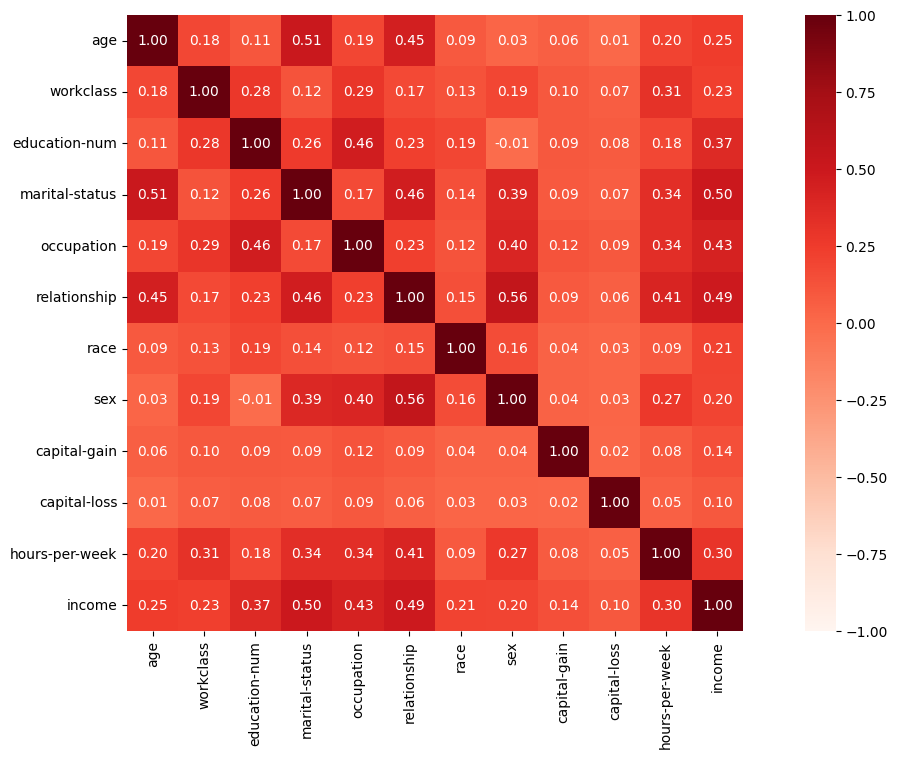

In [3]:
fig, ax = plt.subplots(figsize=(16, 8))
r = associations(df_train, ax=ax, cmap="Reds")

In [4]:
age = pd.qcut(df_train.age, q=5)
age

0        (34.0, 44.0]
1        (51.0, 90.0]
2        (44.0, 51.0]
3        (44.0, 51.0]
4        (34.0, 44.0]
             ...     
39068    (25.0, 34.0]
39069    (51.0, 90.0]
39070    (34.0, 44.0]
39071    (25.0, 34.0]
39072    (34.0, 44.0]
Name: age, Length: 39073, dtype: category
Categories (5, interval[float64, right]): [(16.999, 25.0] < (25.0, 34.0] < (34.0, 44.0] < (44.0, 51.0] < (51.0, 90.0]]

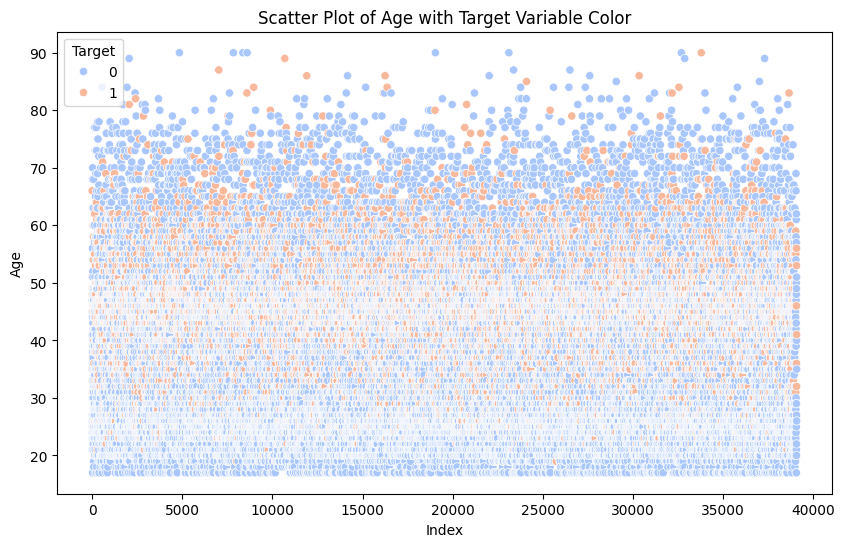

In [5]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_train, x=np.arange(len(df_train)), y="age", hue="income", palette="coolwarm"
)
plt.xlabel("Index")
plt.ylabel("Age")
plt.title("Scatter Plot of Age with Target Variable Color")
plt.legend(title="Target")
plt.show()

/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_48276/1512473390.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Target')


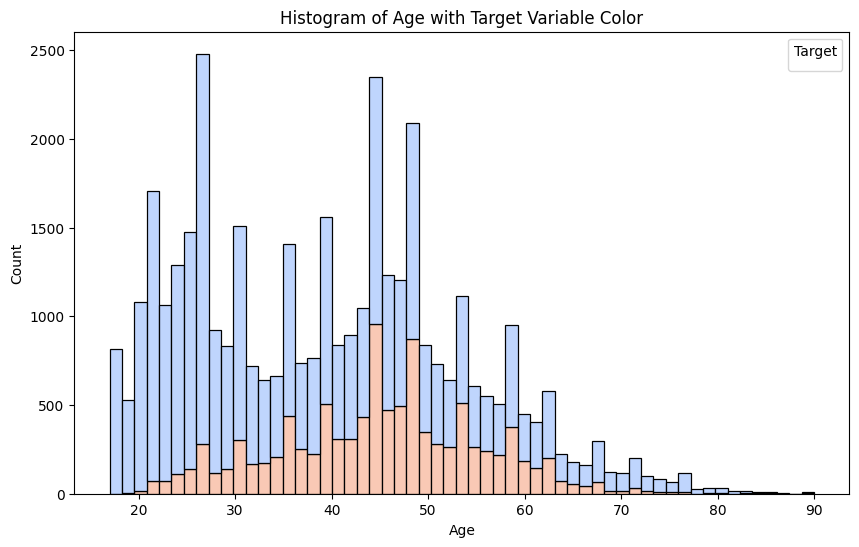

In [6]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x="age", hue="income", multiple="stack", palette="coolwarm")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Histogram of Age with Target Variable Color")
plt.legend(title="Target")
plt.show()

/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_42808/2341410922.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Target')


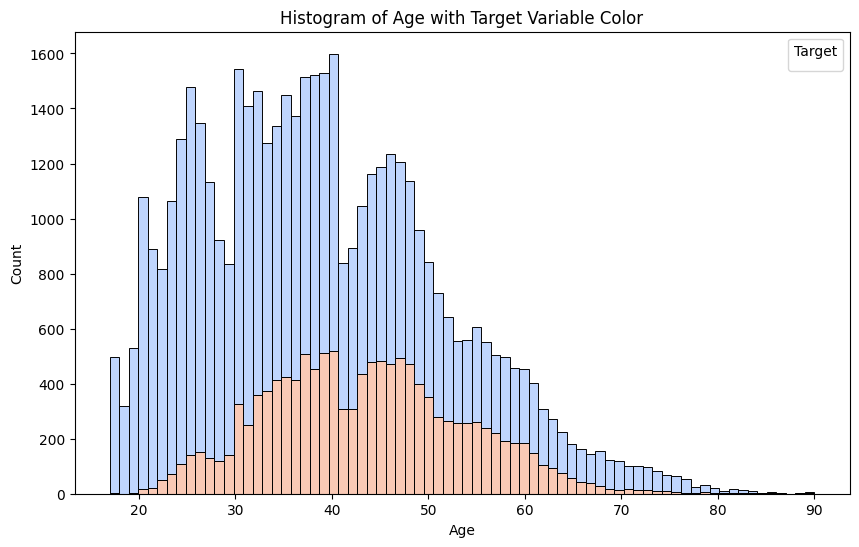

In [7]:
import pandas as pd
import numpy as np

# Define the favorable outcome
favorable_outcome = 1


# Introduce sampling bias: Sample more from age group with favorable outcome
def biased_sampling(df, age_min, age_max, bias_factor=1.5):
    # Split the dataset into the age group of interest and the rest
    age_group = df[(df["age"] >= age_min) & (df["age"] <= age_max)]
    rest_group = df[(df["age"] < age_min) | (df["age"] > age_max)]

    # Determine the size of the biased sample
    sample_size = int(len(age_group) * bias_factor)

    # Sample with replacement from the age group of interest
    biased_sample = age_group.sample(n=sample_size, replace=True)

    # Combine the biased sample with the rest of the dataset
    biased_df = pd.concat([biased_sample, rest_group]).reset_index(drop=True)
    return biased_df


# Apply biased sampling for ages between 30 and 40
biased_df = biased_sampling(df_train, age_min=30, age_max=40, bias_factor=2)

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=biased_df, x="age", hue="income", multiple="stack", palette="coolwarm"
)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Histogram of Age with Target Variable Color")
plt.legend(title="Target")
plt.show()

Original DataFrame shape: (48842, 15)
Biased DataFrame shape: (39603, 15)


/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_42808/68310515.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Target')


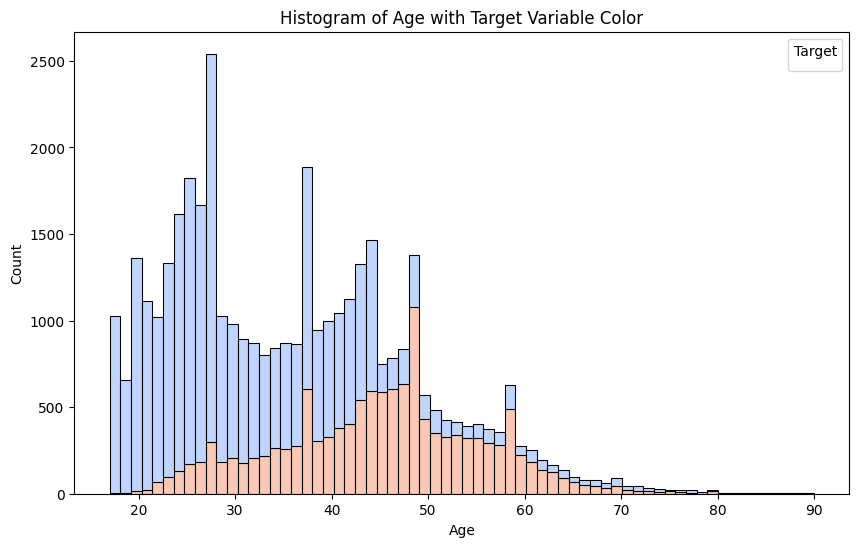

In [8]:
# Introduce sampling bias by reducing the amount of target = 0 rows from age 45-50 and below 45
age_ranges = [(45, 100), (0, 44)]
target_value = 0
keep_fraction_45_50 = (
    0.2  # Keep only 20% of the rows that meet the criteria for age 45-50
)
keep_fraction_below_45 = (
    0.2  # Keep only 50% of the rows that meet the criteria for age below 45
)


# Function to introduce bias for a specific age range
def introduce_bias(df, age_range, target_value, keep_fraction):
    mask = (
        (df["age"] >= age_range[0])
        & (df["age"] <= age_range[1])
        & (df["income"] == target_value)
    )
    rows_to_keep = df[mask].sample(frac=keep_fraction, random_state=0).index
    return df[~mask | df.index.isin(rows_to_keep)]


# Apply bias for age 45-50
biased_df = introduce_bias(df, age_ranges[0], target_value, keep_fraction_45_50)

# Apply bias for age below 45
# biased_df = introduce_bias(biased_df, age_ranges[1], 1, keep_fraction_below_45)

print(f"Original DataFrame shape: {df.shape}")
print(f"Biased DataFrame shape: {biased_df.shape}")

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=biased_df, x="age", hue="income", multiple="stack", palette="coolwarm"
)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Histogram of Age with Target Variable Color")
plt.legend(title="Target")
plt.show()

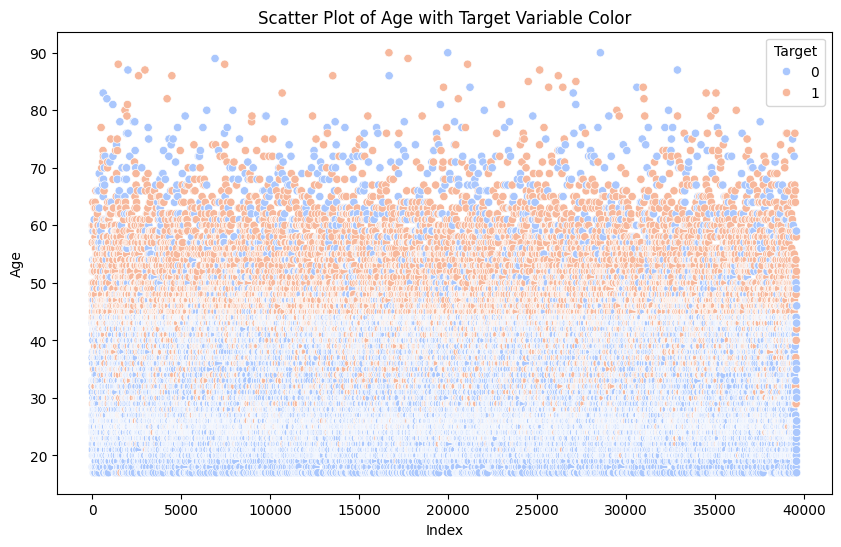

In [9]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=biased_df,
    x=np.arange(len(biased_df)),
    y="age",
    hue="income",
    palette="coolwarm",
)
plt.xlabel("Index")
plt.ylabel("Age")
plt.title("Scatter Plot of Age with Target Variable Color")
plt.legend(title="Target")
plt.show()

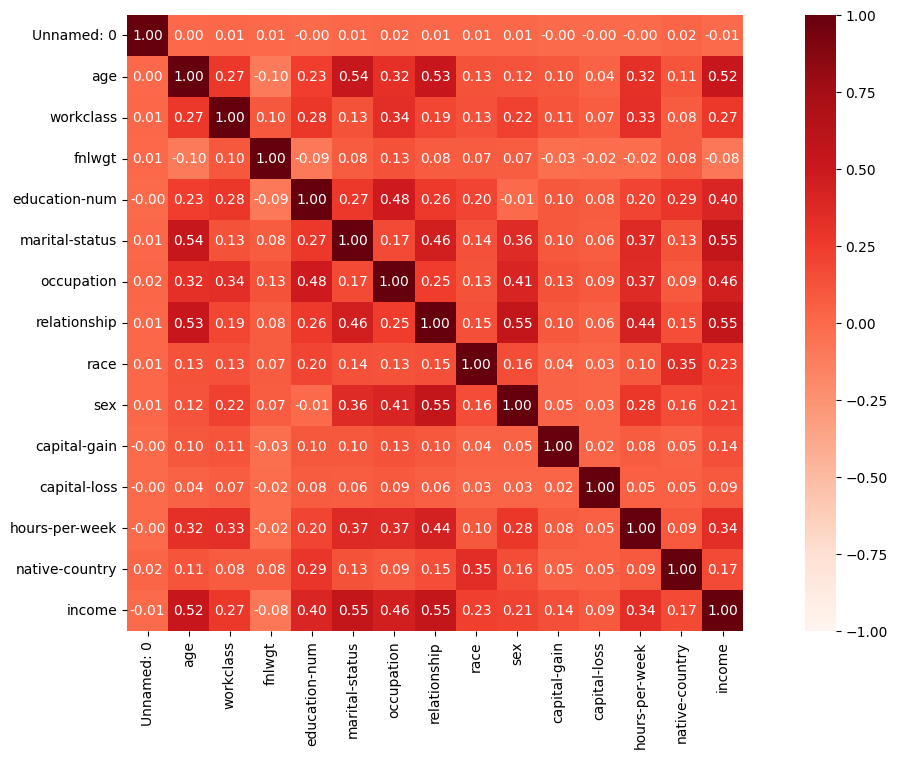

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
r = associations(biased_df, ax=ax, cmap="Reds")

## Introduce skewness

In [38]:
df_train_ = df_train  # biased_df
df_test_ = df_train  # df_test

## Clean data

In [8]:
def clean_data(X):
    X = X.reset_index(drop=True)
    X = X.drop(columns=["fnlwgt", "education"], errors="ignore")
    cols = list(X.columns)
    X[cols] = X[cols].replace([" ?"], np.nan)
    X = X.dropna()

    def strip_str(x):
        if isinstance(x, str):
            return x.strip()
        else:
            return x

    X = X.applymap(strip_str)
    X["relationship"] = X["relationship"].replace(["Husband", "Wife"], "Married")
    X["hours-per-week"] = pd.cut(
        x=X["hours-per-week"],
        bins=[0.9, 25, 39, 40, 55, 100],
        labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"],
    )
    X.age = pd.qcut(X.age, q=7)
    # X['artificial_feature'] = pd.qcut(X['artificial_feature'], q=5)
    X["capital-gain"] = pd.cut(
        X["capital-gain"],
        bins=[-1, 1, 1000, 5000, 10000, 100000, 1000000],
        labels=["None", "Low", "Medium", "High", "VeryHigh", "Rich"],
    )
    X["capital-loss"] = pd.cut(
        X["capital-loss"],
        bins=[-1, 1, 1000, 5000, 10000, 100000, 1000000],
        labels=["None", "Low", "Medium", "High", "VeryHigh", "Rich"],
    )
    return X

In [164]:
df_train__ = df_train_.copy()
df_test__ = df_test_.copy()
df_train_ = clean_data(df_train_)
df_test_ = clean_data(df_test_)

/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_38948/3912755508.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(strip_str)
/var/folders/5s/7wthnl510p9_gg2ytrfvxy180000gn/T/ipykernel_38948/3912755508.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(strip_str)


## Train baseline

In [39]:
def describe_model(y_test, y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred, average='macro')}")
    print(f"Recall: {recall_score(y_test, y_pred, average='macro')}")
    print(f"F1: {f1_score(y_test, y_pred, average='macro')}")

In [66]:
def train_and_evaluate(clf, df_train, df_test, nominal_features, target):
    def _split_data(df_train, df_test, nominal_features, target):
        def split_into_X_y(column_transformer, data):
            X, y = data.drop(target, axis=1), data[target]
            X_transformed = column_transformer.transform(X)

            return (X_transformed, y)

        column_transformer = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore"), nominal_features)
            ],
            # remainder="passthrough",
        )

        column_transformer.fit(df_train)

        X_train, y_train = split_into_X_y(column_transformer, df_train)
        X_test, y_test = split_into_X_y(column_transformer, df_test)

        return X_train, y_train, X_test, y_test

    X_train, y_train, X_test, y_test = _split_data(
        df_train, df_test, nominal_features, target
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_test, y_pred, clf.predict_proba(X_train)[:, 0]

In [67]:
# from sklearn.svm import LinearSVC, SVC

mlp = MLPClassifier(random_state=random_state, max_iter=25)
y_test, y_pred, y_prob = train_and_evaluate(
    mlp, df_train_, df_test_, nominal_features, target
)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [50]:
describe_model(y_test, y_pred)

Accuracy: 0.8524044736774755
Precision: 0.8239048465832347
Recall: 0.7840296401215757
F1: 0.8002319814120893


In [13]:
def add_row(df, index, data):
    df.loc[index] = data


df_utility = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1"])
df_bias = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "disparate_impact",
        "equal_opportunity_difference",
        "average_abs_odds_difference",
        "theil_index",
    ]
)

add_row(
    df_utility,
    "basic_dataset_baseline",
    [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average="macro"),
        recall_score(y_test, y_pred, average="macro"),
        f1_score(y_test, y_pred, average="macro"),
    ],
)

In [14]:
df_train_pred = df_train_.copy()
_, y_pred, _ = train_and_evaluate(
    mlp, df_train_pred, df_train_pred, nominal_features, target
)
df_train_pred["income-predicted"] = y_pred

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


## Fairness Evaluation

In [15]:
features_4_scanning = nominal_features + ordinal_features

In [16]:
def print_report(data, subset):
    """Utility function to pretty-print the subsets."""
    if subset:
        to_choose = data[subset.keys()].isin(subset).all(axis=1)
        df = data[["income", "income-predicted"]][to_choose]
    else:
        for col in features_4_scanning:
            subset[col] = list(data[col].unique())
        df = data[["income", "income-predicted"]]

    true = df["income"].sum()
    pred = df["income-predicted"].sum()

    print("\033[1mSubset: \033[0m")
    print(subset)
    print("\033[1mSubset Size: \033[0m", len(df))
    print("\033[1mTrue Clicks: \033[0m", true)
    print("\033[1mPredicted Clicks: \033[0m", pred)
    print()

### baseline

In [17]:
from aif360.detectors.mdss.ScoringFunctions import Bernoulli
from aif360.detectors.mdss.MDSS import MDSS

# Bias scan
scoring_function = Bernoulli(direction="negative")
scanner = MDSS(scoring_function)

_, y_pred, _ = train_and_evaluate(mlp, df_train_, df_train_, nominal_features, target)
to_delete = df_train_.copy()
to_delete["income-predicted"] = y_pred

scanned_subset, _ = scanner.scan(
    to_delete[features_4_scanning],
    expectations=to_delete["income-predicted"],
    outcomes=to_delete["income"],
    penalty=1,
    num_iters=5,
    verbose=False,
)

print_report(df_train_pred, scanned_subset)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Subset: 
{'race': ['Asian-Pac-Islander', 'Black', 'White'], 'relationship': ['Husband', 'Wife'], 'occupation': ['Adm-clerical', 'Exec-managerial', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support'], 'marital-status': ['Married-civ-spouse']}
Subset Size:  8046
True Clicks:  6179
Predicted Clicks:  7597



In [18]:
import fairlens as fl

fscorer = fl.FairnessScorer(
    df_train_,
    target_attr="income",
    sensitive_attrs=scanned_subset.keys(),
)

fscorer.demographic_report()

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/fairlens/utils.py:223: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col_date = pd.to_datetime(column, errors="coerce")
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/fairlens/utils.py:223: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col_date = pd.to_datetime(column, errors="coerce")
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/fairlens/utils.py:223: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  col_dat

Sensitive Attributes: ['marital-status', 'occupation', 'race', 'relationship']

                                              Group Distance  Proportion  Counts  P-Value
                             Exec-managerial, White    0.273    0.147519    5764 0.00e+00
                               Never-married, White   -0.205    0.208328    8140 0.00e+00
       Married-civ-spouse, Exec-managerial, Husband    0.528    0.086684    3387 0.00e+00
                           Never-married, Own-child   -0.247    0.140557    5492 0.00e+00
                Married-civ-spouse, Exec-managerial    0.504    0.102321    3998 0.00e+00
        Married-civ-spouse, Prof-specialty, Husband    0.617    0.040923    1599 0.00e+00
                              Prof-specialty, White    0.486    0.061628    2408 0.00e+00
                 Married-civ-spouse, Prof-specialty    0.604    0.047347    1850 0.00e+00
Married-civ-spouse, Exec-managerial, White, Husband    0.572    0.072608    2837 0.00e+00
                 Mar

In [30]:
from sklearn.pipeline import Pipeline

categorical_features_onehot_transformer = ColumnTransformer(
    transformers=[
        ("one-hot-encoder", OneHotEncoder(handle_unknown="ignore"), nominal_features),
    ],
    remainder="passthrough",
)

model = Pipeline(
    [
        ("one-hot-encoder", categorical_features_onehot_transformer),
        ("clf", MLPClassifier(verbose=False, max_iter=25, random_state=random_state)),
    ]
)

df_train__ = df_train_.copy()
# df_train__.dropna(inplace=True)
X_train, y_train = df_train__.drop(columns=[target]), df_train__[target]
model = model.fit(X_train, y_train)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [31]:
# showcase model's accuracy
df_test__ = df_test_.copy()
# df_test__.dropna(inplace=True)
X_test, y_test = df_test__.drop(columns=[target]), df_test__[target]
y_pred = model.predict(X_test)

print(f"Accuracy = {(y_test.values == y_pred).sum() / y_test.shape[0]:.2%}")

Accuracy = 82.94%


In [60]:
from aif360.sklearn.detectors.facts import FACTS

# load FACTS framework with:
# - the model to be audited
# - protected attribute "sex" and
# - assigning equal, unit weights to all features for cost computation.
# - no features forbidden from changing, i.e. user can specify any features that cannot change at all.
detector = FACTS(
    clf=model,
    prot_attr=scanned_subset.keys(),
    feature_weights={f: 1 for f in X_train.columns},
    feats_not_allowed_to_change=[],
)

In [ ]:
detector = detector.fit(X_test)

In [57]:
# Detects the top `top_count` most biased groups based on the given metric
# available metrics are:
# - equal-effectiveness
# - equal-choice-for-recourse
# - equal-effectiveness-within-budget
# - equal-cost-of-effectiveness
# - equal-mean-recourse
# - fair-tradeoff
# a short description for each metric is given below
detector.bias_scan(metric="equal-choice-for-recourse", phi=0.1, top_count=3)

In [58]:
# prints the result into a nicely formatted report
detector.print_recourse_report(
    show_action_costs=False,
    show_subgroup_costs=True,
    show_unbiased_subgroups=False,
)

If hours-per-week = FullTime, relationship = Not-in-family:
	Protected Subgroup '(0.418, 1.161]', 12.73% covered
		Make hours-per-week = BrainDrain, relationship = Married with effectiveness 8.74%.
		Make hours-per-week = OverTime, relationship = Married with effectiveness 4.37%.
		Make relationship = Married with effectiveness 1.94%.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup '(-2.387, 0.418]', 11.90% covered
		Make hours-per-week = BrainDrain, relationship = Married with effectiveness 4.19%.
		Make hours-per-week = OverTime, relationship = Married with effectiveness 2.09%.
		Make relationship = Married with effectiveness 0.52%.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup '(1.161, 2.053]', 13.53% covered
		Make hours-per-week = BrainDrain, relationship = Married with effectiveness 4.57%.
		Make hours-per-week = OverTime, relationship = Married with effectiveness 3.20%.
		Make relationship = Married with effectiveness 1.37%.
		Aggregate co

### Next evaluator

In [62]:
from sklearn.pipeline import Pipeline

categorical_features_onehot_transformer = ColumnTransformer(
    transformers=[
        (
            "one-hot-encoder",
            OneHotEncoder(handle_unknown="ignore"),
            df_train_.select_dtypes(include=["object", "category"]).columns.to_list(),
        ),
    ],
    remainder="passthrough",
)

model = Pipeline(
    [
        ("one-hot-encoder", categorical_features_onehot_transformer),
        ("clf", MLPClassifier(verbose=False, max_iter=25, random_state=random_state)),
    ]
)

In [80]:
X_train, y_train = df_train_.drop("income", axis=1), df_train_["income"]
model = model.fit(X_train, y_train)

probs = pd.Series(model.predict_proba(X_train)[:, 0])

In [85]:
from aif360.detectors.mdss_detector import bias_scan

privileged_subset = bias_scan(
    data=X_train,
    observations=y_train,
    scoring="BerkJones",
    expectations=probs,
    overpredicted=True,
    penalty=50,
    alpha=0.24,
    observed=False,
    favorable_value=0,
    mode="binary",
)
unprivileged_subset = bias_scan(
    data=X_train,
    observations=y_train,
    scoring="BerkJones",
    expectations=probs,
    overpredicted=False,
    penalty=50,
    alpha=0.24,
    favorable_value=0,
    observed=False,
    mode="binary",
)

Exception: BerkJones scorer supports scanning in autostrat mode only.

In [84]:
print(privileged_subset)
print(unprivileged_subset)

({}, 0.0)
({}, 1343.2994)


### Ignore

In [203]:
dff = X_train.copy()
dff["observed"] = y_train
dff["probabilities"] = probs.copy()

In [205]:
dff

,Unnamed: 0,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,observed,probabilities
0,2,"(23.0, 26.0]",Private,10,Never-married,Craft-repair,Own-child,White,1,None,None,OverTime,United-States,0,0.000012
1,4,"(26.0, 31.0]",Private,10,Never-married,Adm-clerical,Other-relative,White,0,None,None,FullTime,United-States,0,0.000008
2,6,"(31.0, 38.0]",State-gov,9,Never-married,Adm-clerical,Not-in-family,White,0,None,None,FullTime,United-States,0,0.000026
3,7,"(31.0, 38.0]",Private,10,Divorced,Sales,Not-in-family,White,0,None,None,OverTime,United-States,0,0.000624
4,9,"(23.0, 26.0]",Private,15,Never-married,Exec-managerial,Other-relative,Asian-Pac-Islander,0,None,None,FullTime,Philippines,0,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34852,48833,"(23.0, 26.0]",Never-worked,7,Never-married,Farming-fishing,Other-relative,Amer-Indian-Eskimo,1,None,None,FullTime,?,0,NaN
34853,48834,"(16.999, 23.0]",Private,6,Never-married,Craft-repair,Unmarried,White,1,None,None,OverTime,United-States,0,NaN
34854,48835,"(23.0, 26.0]",?,10,Never-married,?,Own-child,Black,0,None,None,PartTime,United-States,0,NaN
34855,48837,"(23.0, 26.0]",Private,9,Never-married,Sales,Own-child,White,0,None,None,FullTime,United-States,0,NaN


In [206]:
to_choose = dff[privileged_subset[0].keys()].isin(privileged_subset[0]).all(axis=1)
temp_df = dff.loc[to_choose]

"Our detected privileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}".format(
    len(temp_df),
    np.round(temp_df["observed"].mean(), 4),
    np.round(temp_df["probabilities"].mean(), 4),
)

ValueError: No objects to concatenate

In [195]:
to_choose = dff[unprivileged_subset[0].keys()].isin(unprivileged_subset[0]).all(axis=1)
temp_df = dff.loc[to_choose]

"Our detected unprivileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}".format(
    len(temp_df),
    np.round(temp_df["observed"].mean(), 4),
    np.round(temp_df["probabilities"].mean(), 4),
)

'Our detected unprivileged group has a size of 8131, we observe 0.8166 as the average probability of earning >50k, but our model predicts 0.6109'

In [88]:
from aif360.sklearn.detectors import bias_scan
from aif360.sklearn.metrics import mdss_bias_score

priv_sub, priv_score = bias_scan(
    X_train, y_train, probs, pos_label=1, penalty=0.5, overpredicted=True
)
priv = df_train_[priv_sub.keys()].isin(priv_sub).all(axis=1)
priv_sub, priv_score

KeyboardInterrupt: 

In [86]:
print(f"Observed: {dff[priv].observed.mean():.2%}")
print(f"Expected: {dff[priv].probabilities.mean():.2%}")
print(f"n = {sum(priv)}")

priv_unpen = mdss_bias_score(
    y_train, probs, X=X_train, subset=priv_sub, pos_label=1, overpredicted=True, penalty=0
)
print(f"unpenalized score: {priv_unpen:.2f}")

NameError: name 'priv' is not defined

In [161]:
unpriv_sub, unpriv_score = bias_scan(
    X_train, y_train, probs, pos_label=1, penalty=0.5, overpredicted=False
)
unpriv = df_train_[unpriv_sub.keys()].isin(unpriv_sub).all(axis=1)
unpriv_sub, unpriv_score

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in temp_df.groupby(column_name):
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/detectors/mdss/MDSS.py:57: FutureWarning: The default of observed=False is deprecated a

({'artificial_feature': [Interval(4.516, 9.081, closed='right')]}, 45382.2815)

In [162]:
print(f"Observed: {dff[unpriv].observed.mean():.2%}")
print(f"Expected: {dff[unpriv].probabilities.mean():.2%}")
print(f"n = {sum(unpriv)}")

unpriv_unpen = mdss_bias_score(
    y_train, probs, X=X_train, subset=unpriv_sub, pos_label=1, overpredicted=False, penalty=0
)
print(f"unpenalized score: {unpriv_unpen:.2f}")

Observed: 99.93%
Expected: 71.27%
n = 6893
unpenalized score: 45382.78


### Fairness Metrics

In [203]:
from aif360.sklearn.metrics import (
    equal_opportunity_difference,
    average_odds_difference,
    statistical_parity_difference,
    disparate_impact_ratio,
    theil_index,
)


def create_dataset(df, protected_attributes, priveleged_groups) -> pd.DataFrame:
    column_renaming = {}
    for i, col in enumerate(protected_attributes):
        df[f"{col}_index"] = df[col].copy()
        df[f"{col}"] = df[col].map(lambda x: 1 if x in priveleged_groups[i] else 0)
        column_renaming[f"{col}_index"] = f"{col}"

    df.set_index(protected_attributes, inplace=True)
    df = df.rename(columns=column_renaming)

    return df


def calculate_fairness_metrics(
    observed, predictions, protected_attributes, priveleged_group
):
    fairness_metrics = {}

    fairness_metrics["statistical_parity_difference"] = statistical_parity_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["average_odds_difference"] = average_odds_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["disparate_impact"] = disparate_impact_ratio(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["theil_index"] = theil_index(1 + predictions - observed)

    return fairness_metrics

In [204]:
df_train_bias = df_train_.copy()
df_test_bias = df_test_.copy()
df_train_bias.dropna(inplace=True)
df_test_bias.dropna(inplace=True)
df_train_bias = create_dataset(
    df_train_bias, list(scanned_subset.keys()), list(scanned_subset.values())
)
df_test_bias = create_dataset(
    df_test_bias, list(scanned_subset.keys()), list(scanned_subset.values())
)
df_train_bias.head(5)

age    workclass  education-num  \
race relationship occupation marital-status                                    
1    0            0          0                44    Local-gov              6   
     1            1          1                66    State-gov             14   
     0            1          0                45      Private             13   
                  0          0                51  Federal-gov             11   
     1            1          1                44      Private             13   

                                             sex  capital-gain  capital-loss  \
race relationship occupation marital-status                                    
1    0            0          0                 1             0             0   
     1            1          1                 1          5082             0   
     0            1          0                 0             0             0   
                  0          0                 0             0             0   
     1            1          1                 1             0             0   

                                             hours-per-week  income   race  \
race relationship occupation marital-status                                  
1    0            0          0                           40       0  Black   
     1            1          1                           40       1  White   
     0            1          0                           40       0  White   
                  0          0                           40       0  Black   
     1            1          1                           40       1  White   

                                              relationship         occupation  \
race relationship occupation marital-status                                     
1    0            0          0                   Own-child   Transport-moving   
     1            1          1                     Husband     Prof-specialty   
     0            1          0               Not-in-family    Exec-managerial   
                  0          0                   Unmarried  Machine-op-inspct   
     1            1          1                     Husband     Prof-specialty   

                                                 marital-status  
race relationship occupation marital-status                      
1    0            0          0                    Never-married  
     1            1          1               Married-civ-spouse  
     0            1          0                    Never-married  
                  0          0                         Divorced  
     1            1          1               Married-civ-spouse

In [93]:
from sklearn.pipeline import Pipeline

categorical_features_onehot_transformer = ColumnTransformer(
    transformers=[
        (
            "one-hot-encoder",
            OneHotEncoder(handle_unknown="ignore"),
            # df_train_bias.select_dtypes(
            #     include=["object", "category"]
            # ).columns.to_list(),
            nominal_features,
        ),
    ],
    # remainder="passthrough",
)

model = Pipeline(
    [
        ("one-hot-encoder", categorical_features_onehot_transformer),
        ("clf", MLPClassifier(verbose=False, max_iter=25, random_state=random_state)),
    ]
)

train = df_train_bias.copy()
train.dropna(inplace=True)
X_train, y_train = train.drop(columns=[target]), train[target]
model = model.fit(X_train, y_train)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [94]:
test = df_test_.copy()
X_test, y_test = test.drop(columns=[target]), test[target]
y_pred = model.predict(X_test)

print(f"Accuracy = {(y_test.values == y_pred).sum() / y_test.shape[0]:.2%}")

Accuracy = 84.13%


In [95]:
y_pred = model.predict(X_train)
metrics = calculate_fairness_metrics(
    df_train_bias, y_pred, target, list(scanned_subset.keys()), (1, 1, 1, 1)
)
metrics

{'statistical_parity_difference': -0.9152554551062906,
 'average_odds_difference': -0.8392722546577112,
 'equal_opportunity_difference': -0.8269425528599841,
 'disparate_impact': 0.035625508826040424,
 'theil_index': 0.1298333662199809}

In [96]:
from aif360.datasets import StandardDataset


def convert_to_standard_dataset(df, target_label_name, scores_name=""):

    # List of names corresponding to protected attribute columns in the dataset.
    # Note that the terminology "protected attribute" used in AI Fairness 360 to
    # divide the dataset into multiple groups for measuring and mitigating
    # group-level bias.
    protected_attributes = scanned_subset.keys()

    # columns from the dataset that we want to select for this Bias study
    selected_features = df.columns

    # This privileged class is selected based on MDSS subgroup evaluation.
    # in previous steps. In our case non-homeowner (homeowner=0) are considered to
    # be privileged and homeowners (homeowner=1) are considered as unprivileged.
    privileged_classes = scanned_subset.values()

    # Label values which are considered favorable are listed. All others are
    # unfavorable. Label values are mapped to 1 (favorable) and 0 (unfavorable)
    # if they are not already binary and numerical.
    favorable_target_label = [1]

    # List of column names in the DataFrame which are to be expanded into one-hot vectors.
    categorical_features = nominal_features + ordinal_features
    categorical_features = [
        col for col in categorical_features if col not in protected_attributes
    ]

    # create the `StandardDataset` object
    standard_dataset = StandardDataset(
        df=df,
        label_name=target_label_name,
        favorable_classes=favorable_target_label,
        scores_name=scores_name,
        protected_attribute_names=protected_attributes,
        privileged_classes=privileged_classes,
        categorical_features=categorical_features,
        # features_to_keep=selected_features
    )

    if scores_name == "":
        standard_dataset.scores = standard_dataset.labels.copy()

    return standard_dataset

In [97]:
df__ = df_train_.copy()  # pd.concat([df_train__, df_test__])
df__.reset_index(inplace=True, drop=True)
dataset_orig = convert_to_standard_dataset(df__, target_label_name="income")

In [98]:
dataset_pred = dataset_orig.copy()
dataset_pred.labels = y_pred.reshape(-1, 1)
dataset_pred.scores = y_pred.reshape(-1, 1)

In [102]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric


def compute_metrics(
    dataset_true, dataset_pred, unprivileged_groups, privileged_groups, disp=True
):
    """Compute the key metrics"""
    classified_metric_pred = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
    )
    metrics = OrderedDict()
    metrics["Statistical parity difference"] = (
        classified_metric_pred.statistical_parity_difference()
    )
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = (
        classified_metric_pred.average_odds_difference()
    )
    metrics["Equal opportunity difference"] = (
        classified_metric_pred.equal_opportunity_difference()
    )
    metrics["Theil index"] = classified_metric_pred.theil_index()

    if disp:
        for k in metrics:
            print("%s = %f" % (k, metrics[k]))
            # print("%s = %.4f" % (k, metrics[k]))

    return metrics

In [103]:
privileged_groups = [
    {"race": 1, "relationship": 1, "occupation": 1, "marital-status": 1}
]
unprivileged_groups = [
    {"race": 0, "relationship": 0, "occupation": 0, "marital-status": 0}
]
metrics2 = compute_metrics(
    dataset_orig, dataset_pred, unprivileged_groups, privileged_groups
)

Statistical parity difference = -0.949066
Disparate impact = 0.000000
Average odds difference = -0.919378
Equal opportunity difference = -0.973296
Theil index = 0.129833


In [101]:
metrics

{'statistical_parity_difference': -0.9152554551062906,
 'average_odds_difference': -0.8392722546577112,
 'equal_opportunity_difference': -0.8269425528599841,
 'disparate_impact': 0.035625508826040424,
 'theil_index': 0.1298333662199809}

### Mitigation

#### Reweigthing

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

mlp = LogisticRegression(verbose=False, max_iter=1250, random_state=random_state)
mlp.fit(
    dataset_train.features,
    dataset_train.labels.ravel(),
    sample_weight=dataset_train.instance_weights,
)
pred = mlp.predict(dataset_test.features)

scores = {
    "accuracy": accuracy_score(dataset_test.labels, pred),
    "precision": precision_score(dataset_test.labels, pred, average="macro"),
    "recall": recall_score(dataset_test.labels, pred, average="macro"),
    "f1": f1_score(dataset_test.labels, pred, average="macro"),
}
scores

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'accuracy': 0.9382544103992572,
 'precision': 0.9212530638733762,
 'recall': 0.9335645909877349,
 'f1': 0.9270551869185055}

In [176]:
df__ = df_train_bias.copy()
df__["protected_attributes"] = [scanned_subset.keys()] * len(df__)

In [178]:
from aif360.algorithms.preprocessing import Reweighing

RW = Reweighing(
    unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups
)

RW.fit(df__)
dataset_transf_train = RW.transform(df__)

AttributeError: 'DataFrame' object has no attribute 'protected_attribute_names'

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

mlp = LogisticRegression(verbose=False, max_iter=1250, random_state=random_state)
mlp.fit(
    dataset_transf_train.features,
    dataset_transf_train.labels.ravel(),
    sample_weight=dataset_transf_train.instance_weights,
)
pred = mlp.predict(dataset_test.features)

scores = {
    "accuracy": accuracy_score(dataset_test.labels, pred),
    "precision": precision_score(dataset_test.labels, pred, average="macro"),
    "recall": recall_score(dataset_test.labels, pred, average="macro"),
    "f1": f1_score(dataset_test.labels, pred, average="macro"),
}
scores

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'accuracy': 0.853644382544104,
 'precision': 0.8324110661426452,
 'recall': 0.8068914277097914,
 'f1': 0.8178133580524257}

In [80]:
add_row(
    df_utility,
    "reweighted_dataset_mitigated",
    scores.values(),
)

In [81]:
pred = mlp.predict(dataset_transf_train.features)

dataset_train_pred = dataset_transf_train.copy()
dataset_train_pred.labels = pred.reshape(-1, 1)
dataset_train_pred.scores = pred.reshape(-1, 1)

metrics = compute_metrics(
    dataset_transf_train, dataset_train_pred, unprivileged_groups, privileged_groups
)

Balanced accuracy = 0.8845
Statistical parity difference = -0.0466
Disparate impact = 0.8565
Average odds difference = -0.1050
Equal opportunity difference = -0.2463
Theil index = 0.1105


In [82]:
add_row(df_bias, "dataset_with_reweighing_mitigation", list(metrics.values())[1:])

#### Experiments

In [91]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample


def resample_with_weights(X, y, sample_weights):
    # Normalize sample weights to sum to 1
    sample_weights = sample_weights / np.sum(sample_weights)

    # Perform weighted resampling
    n_samples = len(y)
    indices = np.random.choice(
        np.arange(n_samples), size=n_samples, replace=True, p=sample_weights
    )

    # Get the resampled X and y
    X_resampled = X[indices]
    y_resampled = y[indices]

    return X_resampled, y_resampled


# Example data
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()
sample_weights = dataset_transf_train.instance_weights.ravel()

# Resample the dataset according to sample weights
X_resampled, y_resampled = resample_with_weights(X_train, y_train, sample_weights)

# Train the MLPClassifier
mlp = MLPClassifier(random_state=42, max_iter=25)
mlp = mlp.fit(X_resampled, y_resampled)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [92]:
pred = mlp.predict(dataset_test.features)

scores = {
    "accuracy": accuracy_score(dataset_test.labels, pred),
    "precision": precision_score(dataset_test.labels, pred, average="macro"),
    "recall": recall_score(dataset_test.labels, pred, average="macro"),
    "f1": f1_score(dataset_test.labels, pred, average="macro"),
}
scores

{'accuracy': 0.8239322191272052,
 'precision': 0.8575391204316842,
 'recall': 0.7166176029093655,
 'f1': 0.7454096653687703}

In [94]:
pred = mlp.predict(dataset_transf_train.features)

dataset_train_pred = dataset_transf_train.copy()
dataset_train_pred.labels = pred.reshape(-1, 1)
dataset_train_pred.scores = pred.reshape(-1, 1)

metrics = compute_metrics(
    dataset_transf_train, dataset_train_pred, unprivileged_groups, privileged_groups
)

Balanced accuracy = 0.8809
Statistical parity difference = -0.1387
Disparate impact = 0.5361
Average odds difference = -0.2587
Equal opportunity difference = -0.5488
Theil index = 0.1794


##### Second approach

In [304]:
dataset____, attr = dataset_transf_train.convert_to_dataframe()
attr["instance_weights"]
df_train____ = df_train__.copy()
df_train____.dropna(inplace=True)
df_train____ = df_train____[:-2]
len(attr["instance_weights"]), len(df_train____["artificial_feature"])

(34460, 34460)

In [305]:
df_train____["artifical_feature"] = (
    attr["instance_weights"] * df_train____["artificial_feature"]
)

mlp = MLPClassifier(verbose=False, max_iter=25, random_state=random_state)
y_test, y_pred, y_prob = train_and_evaluate(
    mlp, df_train____, df_test__, nominal_features, target
)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [306]:
describe_model(y_test, y_pred)

Accuracy: 0.8417442931722796
Precision: 0.8103901971693033
Recall: 0.7737713522812045
F1: 0.7886313182171065


#### Fair Learning

In [123]:
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option("display.max_columns", None)
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import (
    make_scorer,
    statistical_parity_difference,
    consistency_score,
)
from aif360.sklearn.preprocessing import LearnedFairRepresentations

In [214]:
X_train, y_train = df_train_bias.drop(columns=["income"]), df_train_bias["income"]
X_test, y_test = df_test_bias.drop(columns=["income"]), df_test_bias["income"]
X_train.index = y_train.index = pd.MultiIndex.from_arrays(X_train.index.codes, names=X_train.index.names)
X_test.index = y_test.index = pd.MultiIndex.from_arrays(X_test.index.codes, names=X_test.index.names)
y_train = pd.Series(y_train.factorize(sort=True)[0], index=y_train.index, name=y_train.name)
y_test = pd.Series(y_test.factorize(sort=True)[0], index=y_test.index, name=y_test.name)

In [218]:
# Apply pd.get_dummies to both DataFrames
X_train_encoded = pd.get_dummies(X_train, columns=nominal_features)
X_test_encoded = pd.get_dummies(X_test, columns=nominal_features)

# Ensure both DataFrames have the same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='outer', axis=1, fill_value=0)

# Optionally, you can reset the index to match the original DataFrames
X_train_encoded.index = X_train.index
X_test_encoded.index = X_test.index
X_train_encoded[X_train_encoded.columns] = X_train_encoded[X_train_encoded.columns].astype(int)
X_test_encoded[X_test_encoded.columns] = X_test_encoded[X_test_encoded.columns].astype(int)

In [219]:
from sklearn import metrics as skm


def discrimination(y_true, y_pred):
    return abs(
        statistical_parity_difference(
            y_true,
            y_pred,
            prot_attr=list(scanned_subset.keys()),
            priv_group=(1, 1, 1, 1),
        )
    )


def delta(y_true, y_pred, use_bal_acc=False):
    if use_bal_acc:
        return balanced_accuracy_score(
            y_true, y_pred
        )
    else:
        return accuracy_score(y_true, y_pred) - discrimination(y_true, y_pred)


min_disc = make_scorer(
    statistical_parity_difference,
    prot_attr=list(scanned_subset.keys()),
    priv_group=(1, 1, 1, 1),
)
max_delta = make_scorer(delta, use_bal_acc=False)

In [220]:
#X_train[X_train.columns] = X_train[X_train.columns].astype(int)
#X_test[X_test.columns] = X_test[X_test.columns].astype(int)
#X_train.head(5)

In [222]:
lfr = LearnedFairRepresentations(
    list(scanned_subset.keys()), n_prototypes=25, max_iter=100, random_state=random_state
)
params = {
    #"reconstruct_weight": [1e-2, 1e-3, 1e-4],
    "target_weight": [100, 1000],
    #"fairness_weight": [0, 100, 1000],
}

grid = GridSearchCV(lfr, params, scoring=max_delta, cv=3, n_jobs=-1).fit(
    X_train_encoded, y_train
)
res = pd.DataFrame(grid.cv_results_)
res

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/aif360/sklearn/preprocessing/learning_fair_representations.py:163: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn('lbfgs failed to converge. Increase the number of '
/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_target_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.943927,2.868794,0.026954,0.003422,100,{'target_weight': 100},-0.293350,-0.690165,-0.691750,-0.558421,0.187435,2
1,7.213204,0.291130,0.038939,0.013219,1000,{'target_weight': 1000},-0.267832,-0.332967,-0.298214,-0.299671,0.026611,1


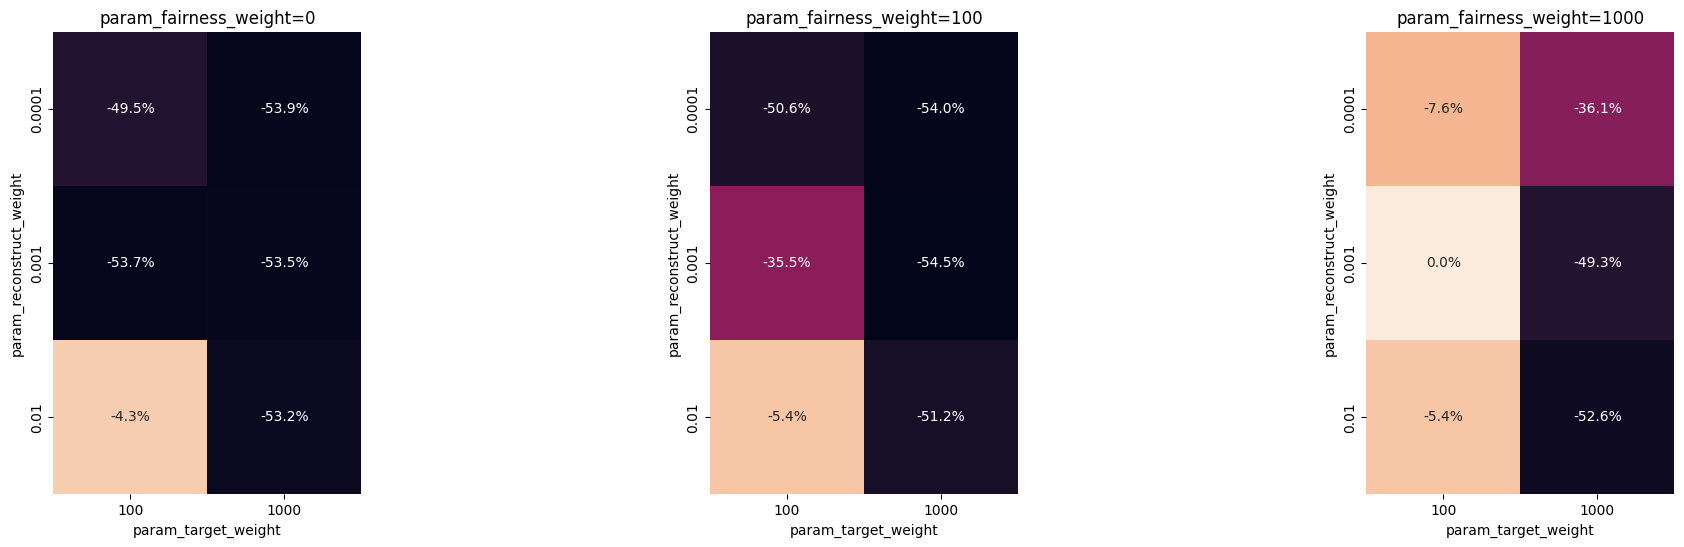

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'res' is your DataFrame and contains the columns mentioned
f, axes = plt.subplots(1, 3, squeeze=True, figsize=(24, 6))
by_fair = res.set_index("param_fairness_weight")

for ax, r in zip(axes, by_fair.index.unique()):
    pivot_table = by_fair.xs(r).pivot(
        index="param_reconstruct_weight",
        columns="param_target_weight",
        values="mean_test_score",
    )
    sns.heatmap(
        pivot_table,
        annot=True,
        fmt=".1%",
        vmin=res["mean_test_score"].min(),
        vmax=res["mean_test_score"].max(),
        square=True,
        cbar=False,
        ax=ax,
    )
    ax.set_title("param_fairness_weight={}".format(r))

plt.show()

In [234]:
y_pred_lfr = grid.predict(X_test_encoded)
mlp = MLPClassifier(max_iter=1000, random_state=random_state)
y_pred_lr = mlp.fit(X_train_encoded, y_train).predict(X_test_encoded)
y_pred_lfr_lr = mlp.fit(grid.transform(X_train_encoded), y_train).predict(X_train_encoded)

In [235]:
print("accuracy_score:", skm.accuracy_score(y_test, y_pred_lfr_lr))
calculate_fairness_metrics(
    y_train,
    y_pred_lfr_lr,
    list(scanned_subset.keys()),
    (1, 1, 1, 1),
)

accuracy_score: 0.7064012535546399


{'statistical_parity_difference': 0.00019728168311800904,
 'average_odds_difference': 3.84052620502079e-06,
 'equal_opportunity_difference': 8.592325106086574e-05,
 'disparate_impact': 1.7765993455940425,
 'theil_index': 0.34726915099741223}

In [ ]:
from aif360.detectors.mdss.ScoringFunctions import Bernoulli
from aif360.detectors.mdss.MDSS import MDSS

# Bias scan
scoring_function = Bernoulli(direction="negative")
scanner = MDSS(scoring_function)

to_delete = grid.transform(X_train_encoded)
to_delete['income'] = y_train
to_delete.reset_index(drop=True, inplace=True)
to_delete["income_predicted"] = y_pred_lfr_lr

scanned_subset, _ = scanner.scan(
    to_delete[['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'relationship_Husband', 'relationship_Not-in-family',
       'relationship_Other-relative', 'relationship_Own-child',
       'relationship_Unmarried', 'relationship_Wife',
       'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'race_Black',
       'race_Other', 'race_White', 'sex_0', 'sex_1']],
    expectations=to_delete["income_predicted"],
    outcomes=to_delete["income"],
    penalty=1,
    num_iters=5,
    verbose=False,
)

In [248]:
scanned_subset

{'race_White': [-1.4940858420301346,
  -1.4507764368482199,
  -1.425120943986268,
  -1.4228516491412095,
  -1.4165189856355629,
  -1.394822877159016,
  -1.3857954340299983,
  -1.3343289380941001,
  -0.2520143752041035,
  -0.24962289612893734,
  -0.13479522669967495,
  -0.12176589894629879]}

In [251]:
X_train2 = grid.transform(X_train_encoded)
X_test2 = grid.transform(X_test_encoded)

X_train2 = create_dataset(X_train2, list(scanned_subset.keys()), list(scanned_subset.values()))
X_test2 = create_dataset(X_test2, list(scanned_subset.keys()), list(scanned_subset.values()))

X_train2.index = y_train.index = pd.MultiIndex.from_arrays(X_train2.index.codes, names=X_train2.index.names)
X_test2.index = y_test.index = pd.MultiIndex.from_arrays(X_test2.index.codes, names=X_test2.index.names)
y_train = pd.Series(y_train.factorize(sort=True)[0], index=y_train.index, name=y_train.name)
y_test = pd.Series(y_test.factorize(sort=True)[0], index=y_test.index, name=y_test.name)


,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,sex_0,sex_1,race_White
race_White,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,29.599076,1.404415,-8.080762,0.331272,20.886712,0.454242,-2.591884,-1.922526,1.967024,-1.207973,-1.053072,-0.020248,-0.539988,1.022564,-1.602519,-8.801040,0.031766,3.525896,-0.772214,-0.571180,-0.578694,-0.988835,0.544663,-3.004825,-1.364248,0.929771,0.883884,1.855100,0.221464,-3.776255,-1.604451,-1.180188,-0.513339,-0.468628,-6.716682,3.007043,0.349282,2.147471,1.135959,-2.957308,0.406225,-0.504610,0.705333,-0.422014,2.576877,-1.115906,-2.538211
0,-31.477269,-6.448309,27.863687,0.366515,-32.061418,0.025763,1.092596,0.311504,0.722405,1.867997,1.131771,0.004172,0.885319,0.329600,2.070431,3.529253,2.331079,-0.855316,0.085260,1.854716,1.791027,1.620501,1.859340,1.905126,1.353276,0.876271,-0.330991,-0.362474,0.001392,2.314725,0.866548,1.373756,2.662174,0.460482,2.596117,1.087575,0.156831,-0.971366,0.118361,0.686067,2.529770,2.166776,1.146428,2.238548,-1.034829,2.261972,1.728881
0,29.702259,6.269418,-7.693885,1.971942,21.221822,0.825126,-1.153645,-1.063506,1.217837,-0.066692,-0.309146,0.837666,0.401032,0.869548,-0.449231,-2.739383,0.175153,1.507289,-0.007887,-0.585309,-0.631307,-0.320431,0.750325,-0.192207,-0.977552,0.889957,0.584732,1.593532,0.864675,-1.140990,-0.675734,-0.311593,0.005648,-0.534268,-1.655815,1.780902,0.730155,1.505952,0.487273,-0.779952,1.020220,0.344980,-0.019589,-0.126944,1.522115,0.367484,-1.022302
0,29.649810,3.618961,-7.909098,1.071777,21.020089,0.617717,-1.936103,-1.530772,1.629247,-0.691897,-0.716456,0.368730,-0.116179,0.953182,-1.079975,-6.047778,0.095248,2.612662,-0.422764,-0.577006,-0.599823,-0.684150,0.632703,-1.729450,-1.190599,0.910395,0.744335,1.732295,0.509743,-2.579900,-1.182559,-0.786059,-0.282857,-0.501308,-4.424818,2.450862,0.519514,1.853228,0.842617,-1.965606,0.679772,-0.121437,0.373896,-0.286274,2.101341,-0.443224,-1.849520
0,29.890113,13.121169,-7.118961,4.344846,21.889486,1.400316,0.857688,0.132163,0.134981,1.567159,0.759391,2.065340,1.768584,0.658447,1.191979,5.837081,0.394744,-1.382111,1.051760,-0.611547,-0.734027,0.613771,1.091135,3.809472,-0.422148,0.853787,0.193892,1.266627,1.817648,2.592496,0.633342,0.918217,0.792088,-0.604735,5.564731,0.048455,1.297899,0.621540,-0.439374,2.277840,1.942702,1.572559,-1.025928,0.278029,-0.000293,2.478076,1.116076


Accuracy: 0.9044800371402043
Precision: 0.8912866151954673
Recall: 0.8763460554115201
F1: 0.8832939497325631


Accuracy: 0.7122794800371403
Precision: 0.7277874987111761
Recall: 0.7717533272359768
F1: 0.703881218446319


#### Fair Adapt

In [101]:
df_train____ = df__.copy()
df_train____["artificial_feature"] = df_train____["artificial_feature"].apply(
    lambda x: 1 if x >= -2.9379999999999997 and x <= 2.043 else 0
)
df_train____.dropna(inplace=True)
df_train____.set_index(["artificial_feature"], drop=False, inplace=True)

# df_train____ = pd.get_dummies(df_train____, prefix_sep='__', drop_first=True, dtype=int)
X_train, y_train = df_train____.drop(columns=["income"]), df_train____["income"]
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, train_size=0.8, shuffle=False, random_state=random_state
)

In [102]:
df_train = pd.concat([X_train, y_train], axis=1)

adj_mat = pd.DataFrame(
    np.zeros((len(df_train.columns), len(df_train.columns)), dtype=int),
    index=df_train.columns.values,
    columns=df_train.columns.values,
)

# Construct the adjacency matrix of the causal graph
adj_mat.loc[
    ["sex", "age", "race"],
    [
        "marital-status",
        "education-num",
        "workclass",
        "hours-per-week",
        "occupation",
        "income",
    ],
] = 1
adj_mat.loc[
    "marital-status",
    ["education-num", "workclass", "hours-per-week", "occupation", "income"],
] = 1
adj_mat.loc[
    "education-num", ["workclass", "hours-per-week", "occupation", "income"]
] = 1
adj_mat.loc[["workclass", "hours-per-week", "occupation"], "income"] = 1
adj_mat.loc["artificial_feature", "income"] = 1
adj_mat.loc[["marital-status", "occupation", "relationship"], "artificial_feature"] = 1

In [103]:
from aif360.sklearn.preprocessing import FairAdapt

FA = FairAdapt(prot_attr="artificial_feature", adj_mat=adj_mat)
Xf_train, yf_train, Xf_test = FA.fit_transform(X_train, y_train, X_test)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


In [104]:
from sklearn.pipeline import Pipeline

categorical_features_onehot_transformer = ColumnTransformer(
    transformers=[
        ("one-hot-encoder", OneHotEncoder(handle_unknown="ignore"), nominal_features),
    ],
    remainder="passthrough",
)

model = Pipeline(
    [
        ("one-hot-encoder", categorical_features_onehot_transformer),
        ("clf", MLPClassifier(verbose=False, max_iter=25, random_state=random_state)),
    ]
)

In [105]:
Xf_train["artificial_feature"] = Xf_train["artificial_feature"].astype(int)
Xf_test["artificial_feature"] = Xf_test["artificial_feature"].astype(int)

In [106]:
y_pred_lr = model.fit(X_train, y_train).predict(X_test)
y_pred_lfr_lr = model.fit(Xf_train, yf_train).predict(Xf_test)

/Users/maxkleinegger/Documents/TUWien/2023WS/BA/.ba-thesis/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


In [107]:
add_row(
    df_utility,
    "fair_adapt_dataset_mitigated",
    [
        accuracy_score(y_test, y_pred_lfr_lr),
        precision_score(y_test, y_pred_lfr_lr, average="macro"),
        recall_score(y_test, y_pred_lfr_lr, average="macro"),
        f1_score(y_test, y_pred_lfr_lr, average="macro"),
    ],
)

In [143]:
print(
    "statistical_parity_difference: ",
    statistical_parity_difference(
        y_test, y_pred_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "average_odds_difference: ",
    average_odds_difference(
        y_test, y_pred_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "equal_opportunity_difference: ",
    equal_opportunity_difference(
        y_test, y_pred_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "average_odds_error:",
    average_odds_error(
        y_test, y_pred_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "disperate impact",
    disparate_impact_ratio(
        y_test, y_pred_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print("theil_index", theil_index(1 + y_pred_lr - y_test))

statistical_parity_difference:  0.6801083495345629
average_odds_difference:  0.48823794734362436
equal_opportunity_difference:  0.6421279937180998
average_odds_error: 0.48823794734362436
disperate impact 160.2999238705274
theil_index 0.07313420925170272


In [137]:
print(
    "statistical_parity_difference: ",
    statistical_parity_difference(
        y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "average_odds_difference: ",
    average_odds_difference(
        y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "equal_opportunity_difference: ",
    equal_opportunity_difference(
        y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "average_odds_error:",
    average_odds_error(
        y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print(
    "disperate impact",
    disparate_impact_ratio(
        y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
    ),
)
print("theil_index", theil_index(1 + y_pred_lfr_lr - y_test))

statistical_parity_difference:  0.39558843876372324
average_odds_difference:  -0.045598145922633504
equal_opportunity_difference:  -0.08244994110718495
average_odds_error: 0.045598145922633504
disperate impact 2.0512982078130304
theil_index 0.0803769807750931


In [139]:
add_row(
    df_bias,
    "dataset_with_fairAdapt_mitigation",
    [
        statistical_parity_difference(
            y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
        ),
        disparate_impact_ratio(
            y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
        ),
        equal_opportunity_difference(
            y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
        ),
        average_odds_difference(
            y_test, y_pred_lfr_lr, prot_attr=["artificial_feature"], priv_group=(1)
        ),
        theil_index(1 + y_pred_lfr_lr - y_test),
    ],
)

In [117]:
describe_model(y_test, y_pred_lr)

Accuracy: 0.9044800371402043
Precision: 0.8912866151954673
Recall: 0.8763460554115201
F1: 0.8832939497325631


In [118]:
describe_model(y_test, y_pred_lfr_lr)

Accuracy: 0.7122794800371403
Precision: 0.7277874987111761
Recall: 0.7717533272359768
F1: 0.703881218446319


In [144]:
df_utility

,accuracy,precision,recall,f1
basic_dataset_baseline,0.841744,0.810390,0.773771,0.788631
cleaned_dataset_baseline,0.842466,0.830543,0.776175,0.795591
bias_dataset_baseline,0.897516,0.887986,0.861080,0.872880
reweighted_dataset_mitigated,0.853644,0.832411,0.806891,0.817813
fair_learning_without_transform_dataset_mitigated,0.703691,0.351845,0.500000,0.413039
fair_learning_dataset_mitigated,0.707173,0.622599,0.549414,0.532666
fair_adapt_dataset_mitigated,0.712279,0.727787,0.771753,0.703881


In [175]:
df_bias

,statistical_parity_difference,disparate_impact,equal_opportunity_difference,average_abs_odds_difference,theil_index
dataset_without_bias_mitigation,0.653144,485.493061,0.537933,0.783130,0.078239
dataset_with_reweighing_mitigation,-0.046592,0.856484,-0.105001,-0.246308,0.110473
dataset_with_fairlearning_mitigation,0.395588,2.051298,-0.082450,-0.045598,0.080377
dataset_with_grid_fairlearning_mitigation,0.000000,0.000000,0.000000,0.000000,0.351416
dataset_with_fairAdapt_mitigation,0.395588,2.051298,-0.082450,-0.045598,0.080377
